In [1]:
from datetime import datetime
import os
import time
from functools import cache, wraps
from io import BytesIO
from pathlib import Path
from zipfile import ZipFile

import duckdb
import folium
import httpx
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [2]:
def download_if_outdated(threshold_seconds):
    def decorator(download_func):
        @wraps(download_func)
        def wrapper(*args, **kwargs):
            extract_dir = Path(kwargs.get("extract_dir", "../data/road_traffic_counts_hourly_permanent"))
            # Ensure the directory exists
            extract_dir.mkdir(parents=True, exist_ok=True)

            # Check if the directory is not empty
            if extract_dir.exists() and any(extract_dir.iterdir()):
                now = time.time()

                # Check the age of the first file in the directory
                first_file = next(extract_dir.iterdir())
                file_mod_time = os.path.getmtime(first_file)
                mod_time_datetime = datetime.fromtimestamp(file_mod_time)


                # If the file is newer than the threshold, skip the download
                if now - file_mod_time < threshold_seconds:
                    print(f"Files are up-to-date. Skipping download. Last update: {mod_time_datetime.strftime('%a, %d %b %Y %H:%M:%S')}")
                    return [path.as_posix() for path in extract_dir.glob("*/*.csv")]

            # If the files are older than the threshold, or the directory is empty, call the download function
            return download_func(*args, **kwargs)

        return wrapper

    return decorator

In [3]:
DOWNLOAD_THRESHOLD_DAYS = 2

TABLE_NAME_COUNTS = "road_traffic_counts"
TABLE_NAME_STATIONS = "station_reference"

CSV_FILES_PATH = "../data/road_traffic_counts_hourly_permanent/"

HOURLY_COUNT_ZIP = "https://opendata.transport.nsw.gov.au/dataset/ef2b0bd2-db1e-48f3-9ea1-2bb9e6bc6504/resource/bca06c7e-30be-4a90-bc8b-c67428c0823a/download/road_traffic_counts_hourly_permanent.zip"
STATION_REFERENCE = "https://opendata.transport.nsw.gov.au/dataset/ef2b0bd2-db1e-48f3-9ea1-2bb9e6bc6504/resource/c65ad7b4-0257-4cc6-953e-5299ac8d27ba/download/road_traffic_counts_station_reference.csv"

In [4]:
@download_if_outdated(threshold_seconds=DOWNLOAD_THRESHOLD_DAYS * 24 * 60 * 60)  # 2 days in seconds
def download_extract_hourly_road_count_data():
    extract_dir = Path(CSV_FILES_PATH)
    extract_dir.mkdir(parents=True, exist_ok=True)

    with httpx.Client() as client:
        response = client.get(HOURLY_COUNT_ZIP)

    with ZipFile(BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_dir)

    return [path.as_posix() for path in extract_dir.glob("*/*.csv")]

In [5]:
csv_files = download_extract_hourly_road_count_data()

Files are up-to-date. Skipping download. Last update: Wed, 20 Mar 2024 19:19:03


In [6]:
@cache
def load_data_duckdb():
    con = duckdb.connect()

    con.execute(
        f"CREATE TABLE {TABLE_NAME_STATIONS} AS SELECT * FROM read_csv_auto('{STATION_REFERENCE}')"
    )

    # Assume the first file defines the table structure
    con.execute(f"CREATE TABLE {TABLE_NAME_COUNTS} AS SELECT * FROM read_csv_auto('{csv_files[0]}')")

    # For each subsequent file, insert the data into the existing table
    for csv_file in csv_files[1:]:
        con.execute(f"INSERT INTO {TABLE_NAME_COUNTS} SELECT * FROM read_csv_auto('{csv_file}')")

    df = con.sql(f"SELECT * FROM {TABLE_NAME_COUNTS}").to_df()
    stats = pd.DataFrame(df.describe())
    stats_all = pd.DataFrame(df.describe(include="all"))

    # stats_objects = df.describe(include=[object])
    return df, stats, stats_all, con

In [7]:
df, stats, stats_all, con = load_data_duckdb()

In [8]:
def show_schema(table_name):
    schema = con.execute(f"DESCRIBE {table_name}").fetch_df()
    return schema[["column_name", "column_type", "null"]]

In [9]:
show_schema(TABLE_NAME_COUNTS);

In [10]:
show_schema(TABLE_NAME_STATIONS);

In [11]:
def query_station_info(or_like_text=['%Victoria Road%', '%Lyons Road%'], exclude_station_id=["18031", "11139", "19035"]):
    # Convert the list of station IDs to exclude into a SQL-compatible string
    exclude_station_id_sql = ", ".join(f"'{id}'" for id in exclude_station_id)
    
    # Dynamically build the ILIKE conditions based on or_like_text
    like_conditions = " OR ".join([f"full_name ILIKE '{text}'" for text in or_like_text])
    
    # Construct the full SQL query
    station_sql_query = f"""
        SELECT * FROM {TABLE_NAME_STATIONS}
        WHERE ({like_conditions})
        AND station_id NOT IN ({exclude_station_id_sql});
    """
    
    # Execute the query and return the DataFrame
    station_df = con.sql(station_sql_query).to_df()
    return station_df

In [12]:
station_df = query_station_info()
vic_rd_stations = station_df["station_key"].unique().tolist()

In [13]:
result = con.execute(f"SELECT COUNT(*) FROM {TABLE_NAME_COUNTS}").fetchone()

# result now contains the count of rows, which is the first (and only) element in the returned tuple
row_count = result[0]

print(f"Number of rows in {TABLE_NAME_COUNTS}: {row_count}")
assert len(df) == row_count

Number of rows in road_traffic_counts: 3637583


In [14]:
def plot_counts_for_station_key_by_hour(station_key, hour, start_year="2018"):
    df = con.sql(
        f"SELECT date, hour_{hour:02}, daily_total FROM {TABLE_NAME_COUNTS} WHERE station_key = {station_key} AND classification_seq = 2 ORDER BY date ASC"
    ).to_df()
    quantile_max = round(df[f"hour_{hour:02}"].quantile(0.999) / 100) * 100  # round to nearest 100
    start_datetime = pd.to_datetime(f"{start_year}-01-01")
    current_date_datetime = pd.to_datetime("now")
    df.plot(
        x="date", y=f"hour_{hour:02}", xlim=[start_datetime, current_date_datetime], ylim=[0, quantile_max]
    )
    return df

/Users/mjboothaus/code/github/databooth/victoria-road/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


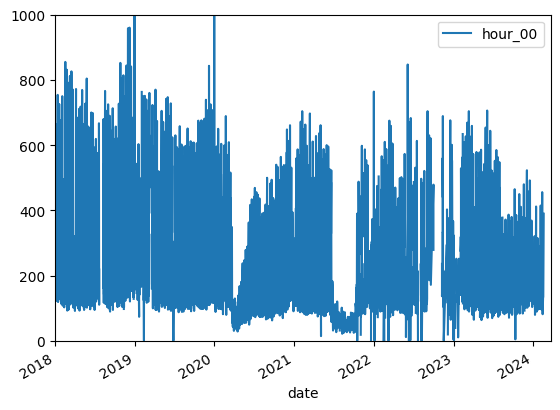

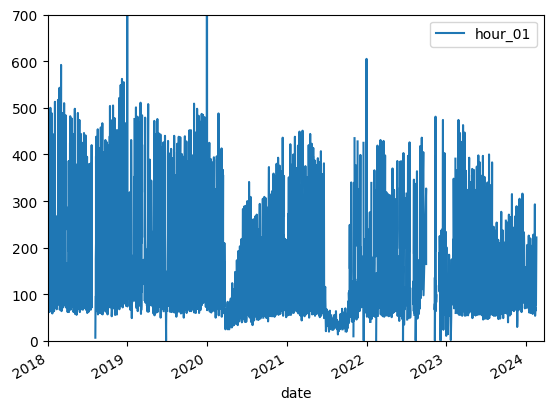

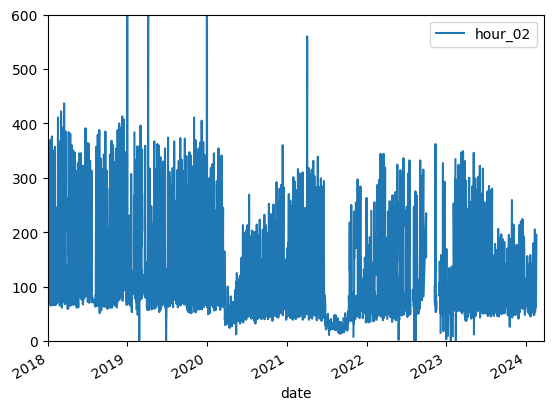

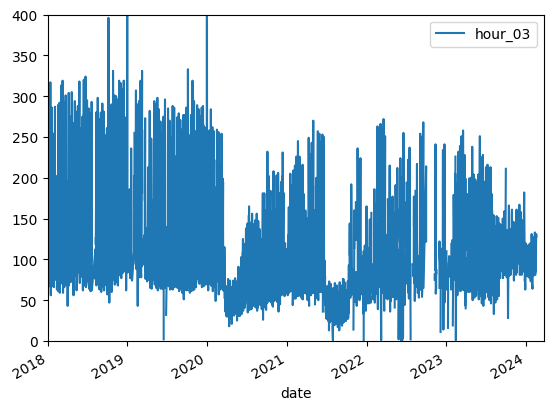

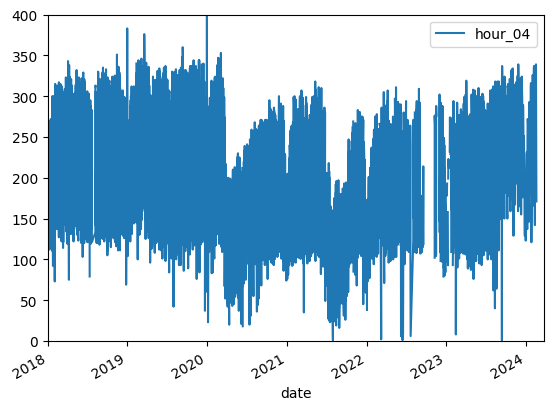

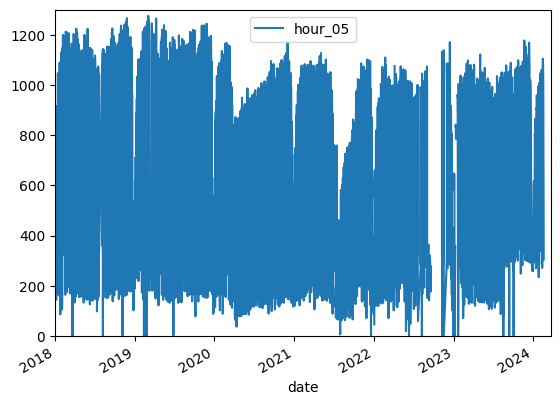

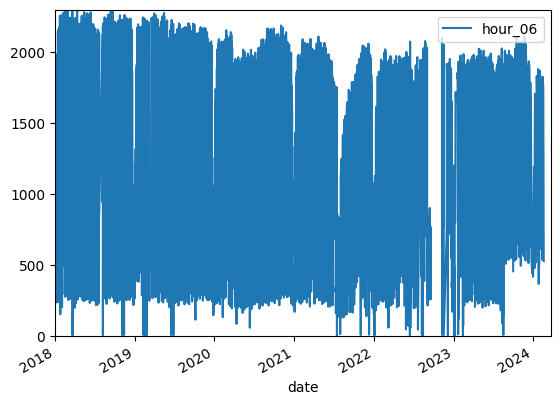

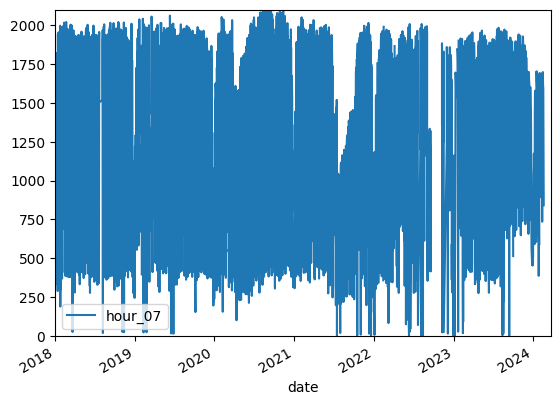

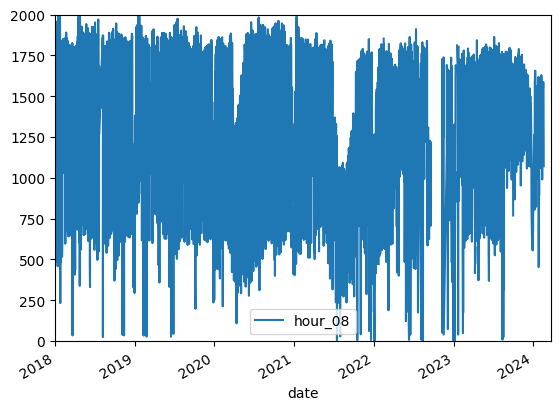

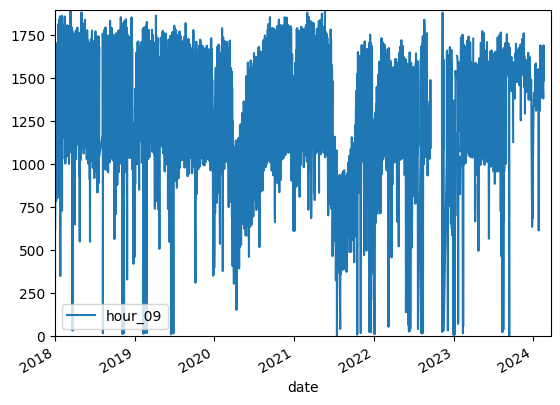

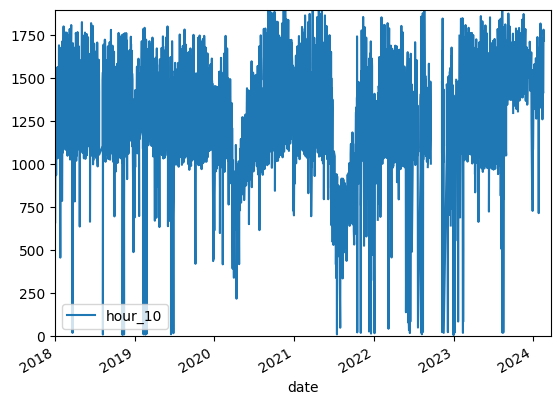

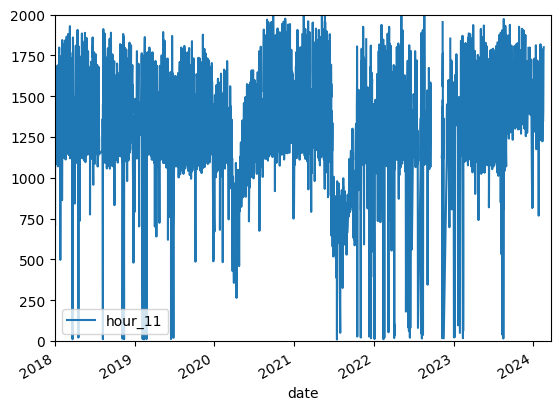

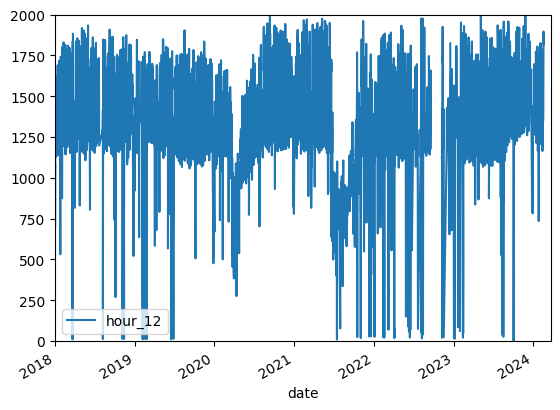

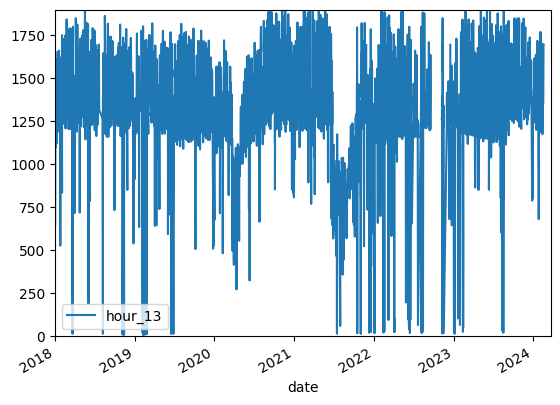

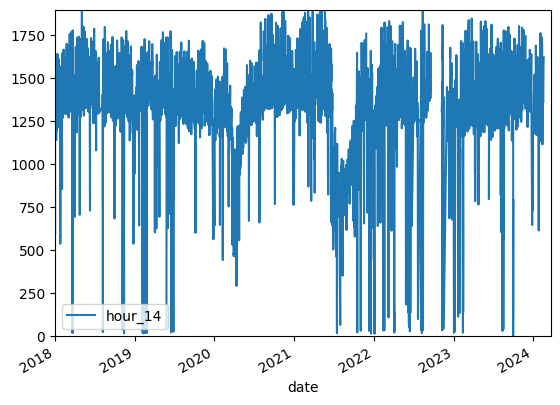

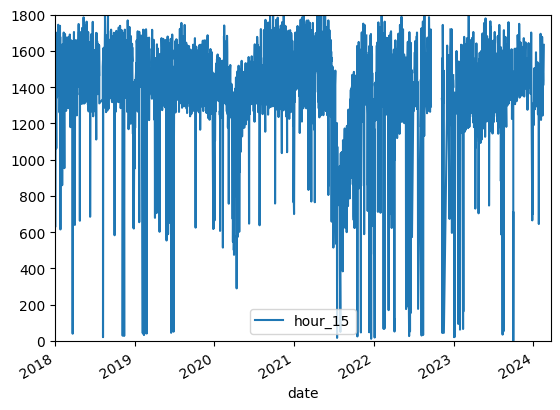

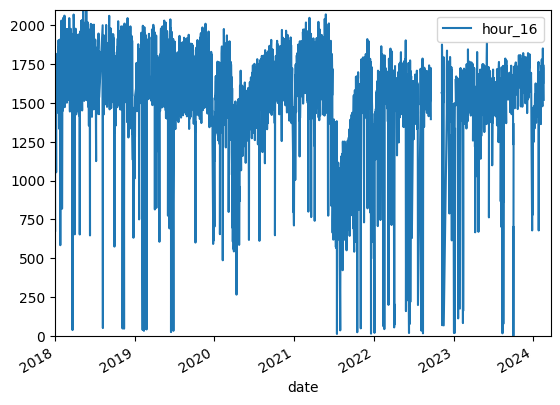

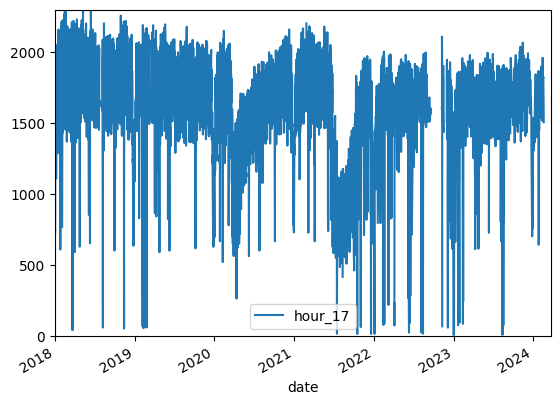

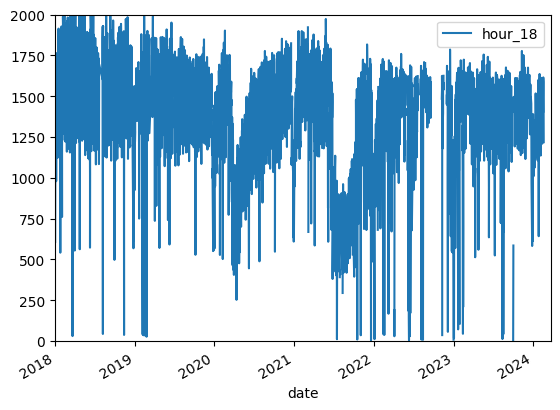

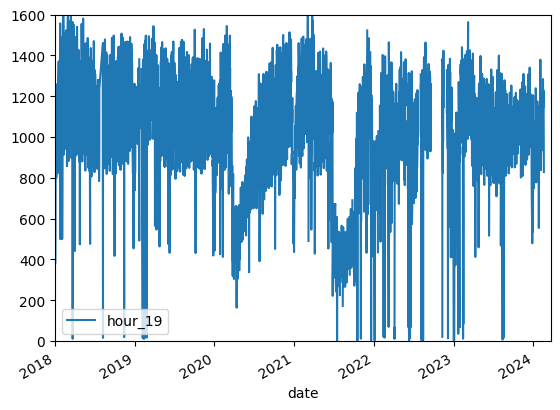

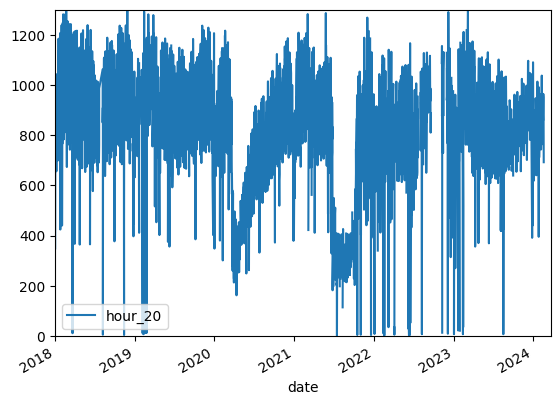

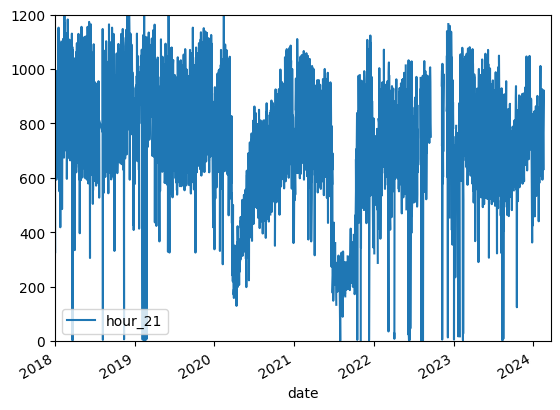

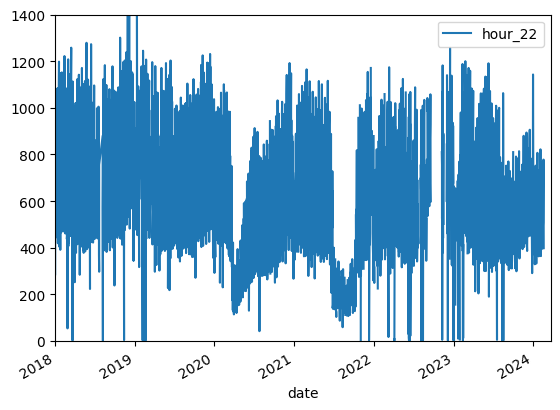

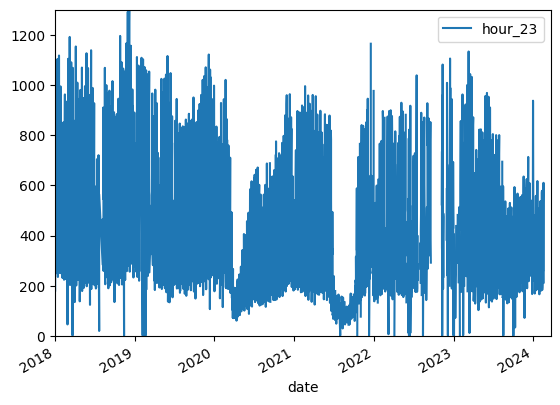

In [15]:
df_all = {}
quantiles = {}
for hour in range(0, 24):
    df_all[hour] = plot_counts_for_station_key_by_hour("99990010", hour)

In [16]:
# def plotly_hourly_count(df, year_start=year_start_datetime):
#     # Assuming df is your DataFrame and it contains a 'date' column and multiple 'hour_xx' columns

#     df_plot = df.copy()
#     df_plot = df_plot[df_plot["date"] >= year_start]
#     # Create a figure with a slider
#     fig = make_subplots(specs=[[{"secondary_y": True}]])

#     # Add traces for each hour, assuming hours 0 through 23
#     for hour in range(24):
#         fig.add_trace(
#             go.Scatter(x=df["date"], y=df[f"hour_{hour:02}"], name=f"Hour {hour}"),
#             secondary_y=False,
#         )

#     # Create and add slider
#     steps = []
#     for i, hour in enumerate(range(24)):
#         step = dict(method="update", args=[{"visible": [False] * 24}], label=f"Hour {hour}")
#         step["args"][0]["visible"][i] = True  # Toggle i-th trace to "visible"
#         steps.append(step)

#     sliders = [dict(active=0, currentvalue={"prefix": "Hour: "}, pad={"t": 50}, steps=steps)]

#     fig.update_layout(sliders=sliders)
#     return fig

In [17]:
# fig = plotly_hourly_count()
# fig.show()

In [18]:
def plot_counts_for_station_key(station_key):
    # df = con.sql(f"SELECT * FROM {TABLE_NAME_COUNTS} WHERE station_key = {station_key} ORDER BY date").to_df()
    df = con.sql(
        f"SELECT date, daily_total FROM {TABLE_NAME_COUNTS} WHERE station_key = {station_key} AND classification_seq = 2 ORDER BY date ASC"
    ).to_df()
    if len(df) > 0:
        df.plot(x="date", y="daily_total", ylim=[0, 40000], legend=f"Station key: {station_key}")
        return df
    else:
        print(f"Station key: {station_key} has no data")
        return station_key

In [19]:
def plot_daily_counts_all_vic_rd_stations():
    df_all = {}
    station_key_no_data = []

    for station_key in vic_rd_stations:
        result = plot_counts_for_station_key(station_key)
        if isinstance(result, pd.DataFrame):
            df_all[station_key] = result
        else:
            station_key_no_data.append(result)
    return df_all, station_key_no_data

Station key: 56708 has no data
Station key: 56844 has no data
Station key: 56853 has no data
Station key: 57078 has no data
Station key: 56855 has no data
Station key: 57058 has no data
Station key: 57033 has no data
Station key: 57084 has no data
Station key: 57085 has no data
Station key: 57042 has no data


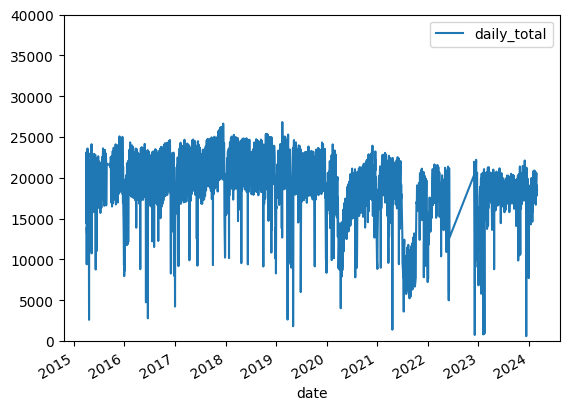

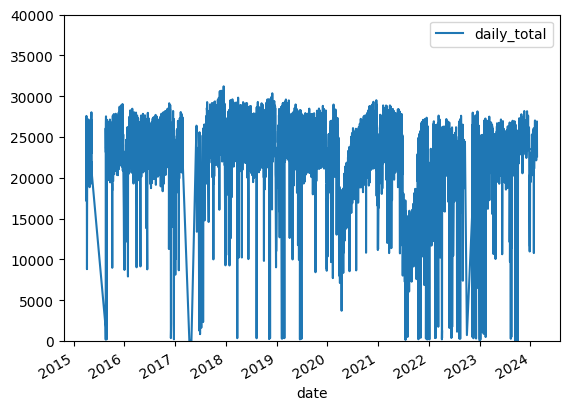

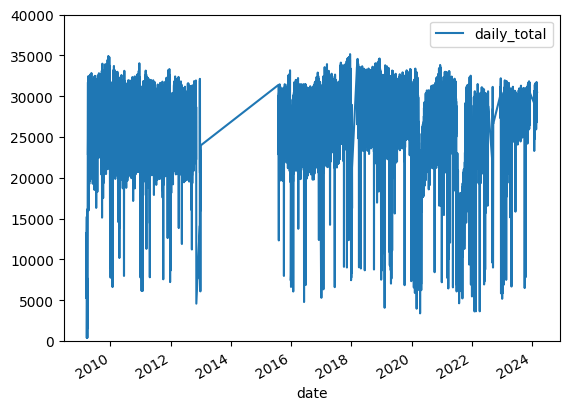

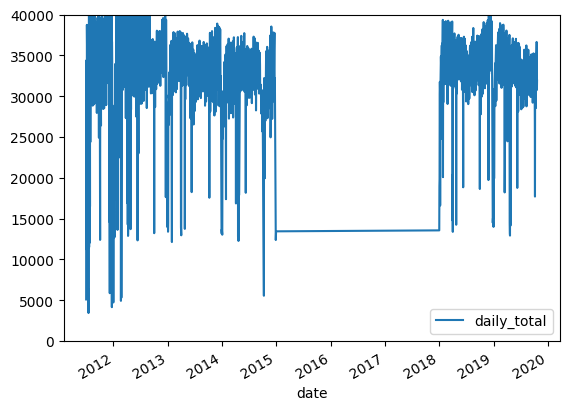

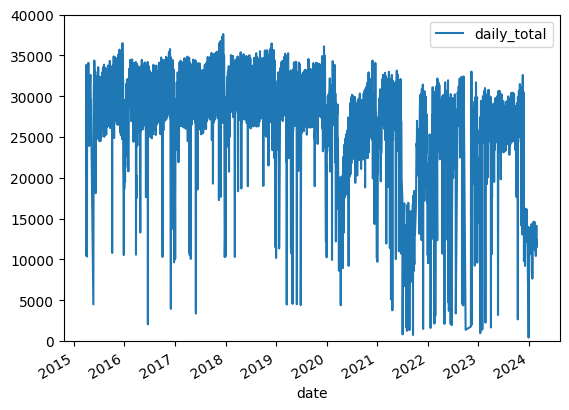

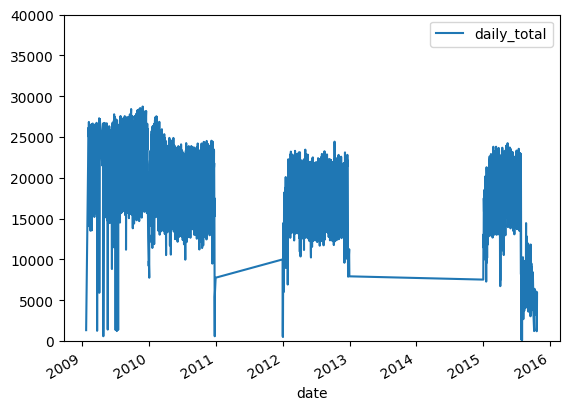

In [20]:
df_all, station_key_no_data = plot_daily_counts_all_vic_rd_stations()

In [21]:
def plot_daily_counts_all_vic_rd_stations_one_figure(df_all):
    # Determine the number of subplots needed
    n = len(df_all)
    cols = 3  # Number of columns in the subplot grid
    rows = n // cols + (n % cols > 0)  # Calculate rows needed, round up if there's a remainder

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Adjust figsize as needed
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

    # Flatten the array of axes for easy iteration
    axs = axs.ravel()

    for i, (station_key, df) in enumerate(df_all.items()):
        # Assuming 'date' is your x-axis and 'daily_total' is your y-axis
        axs[i].plot(df['date'], df['daily_total'])
        axs[i].set_title(f"Station {station_key}")
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Daily Count')
        axs[i].tick_params(axis='x', rotation=45)  # Rotate date labels for better readability

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        axs[j].axis('off')

    plt.show()

    

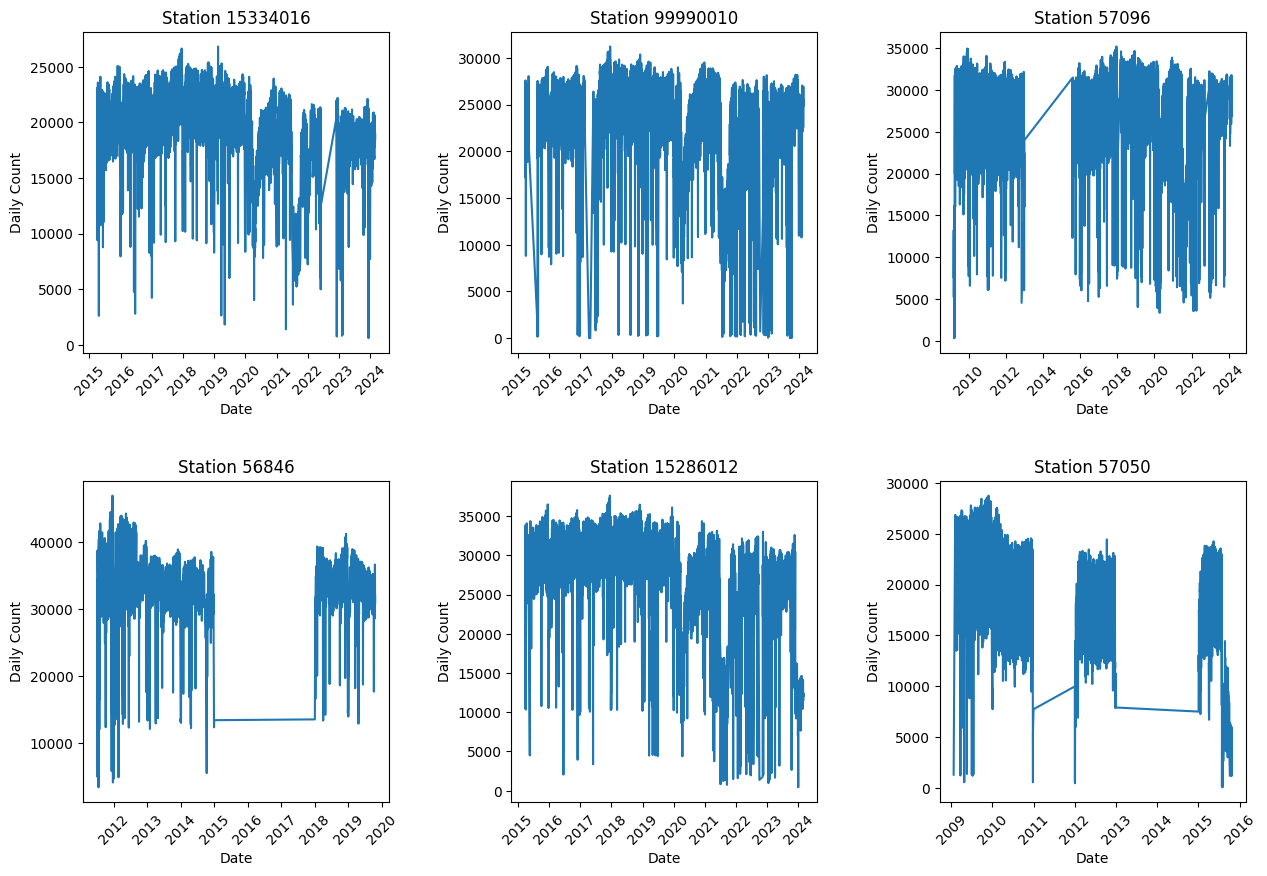

In [22]:
plot_daily_counts_all_vic_rd_stations_one_figure(df_all)

In [23]:
len(df_all)

6

In [24]:
print([table_name[0] for table_name in con.execute("SHOW TABLES;").fetchall()])

['road_traffic_counts', 'station_reference']


In [25]:
def map_selected_stations(station_df):
    # Assuming df has 'wgs84_latitude', 'wgs84_longitude', 'station_id', 'station_key', and 'full_name' columns
    
    m = folium.Map()
    fg = folium.FeatureGroup()  # Create a feature group

    # Add markers to the feature group with popups using itertuples for efficiency
    for row in station_df.itertuples():
        popup_text = f"Station ID (Key): {row.station_id} ({row.station_key})<br>Full Name: {row.full_name}"
        marker = folium.Marker(
            [row.wgs84_latitude, row.wgs84_longitude],
            popup=folium.Popup(popup_text, max_width=450),
        )
        fg.add_child(marker)
    m.add_child(fg)
    m.fit_bounds(fg.get_bounds())
    return m

In [26]:
m = map_selected_stations(station_df)

In [27]:
m